In [1]:
import re
import pandas as pd
import numpy as np
import json
import subprocess
import glob
import os

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.style.use('ggplot')
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

In [8]:
N_SEEDS = 3
N_SEI = 10
N_TESTS = 1
N_TICKS = 260
N_TICKS_DISPLAY = 260

In [17]:
def read_error_data_from_log(file, data_):
    regex_error_savings = re.compile('(INFO:\sNEGATIVE\sSAVINGS\s*)')
    regex_error_small_system = re.compile('(INFO:\sSMALL\sSYSTEM\s*)')
    N_SMALL_SAVINGS = 0
    N_SMALL_SYSTEMS = 0
    
    with open(file) as infile:
        for line in infile:
            if regex_error_savings.search(line):
                res = re.split(regex_error_savings, line)
                N_SMALL_SAVINGS = N_SMALL_SAVINGS + 1
            elif regex_error_small_system.search(line):
                res = re.split(regex_error_small_system, line)
                N_SMALL_SYSTEMS = N_SMALL_SYSTEMS + 1
            else:
                pass
            
    
    return (N_SMALL_SAVINGS, N_SMALL_SYSTEMS)

In [18]:
#Reads data from the given file into the given list
def read_data_from_log(file, data_):
    regex_begin_tick = re.compile('(N\s*active\s*agents\s*at\s*tick\s*)')
    regex_end_tick = re.compile('(Number\s*of\s*installed\s*projects\s*:\s*)')
    regex_data =  re.compile('(INFO:\s)')
    regex_data_check = re.compile('EParamTypes')
    regex_enum = re.compile('(::[\w]*\s*:\s*)')
    regex_enum_name = re.compile('([^:\s]+)')
    regex_1 = re.compile('(\s*:\s*)')
    
    
    with open(file) as infile:
        for line in infile:
            if regex_begin_tick.search(line):
                #parse tick number 
                #start new dictionary in the list
                data_.append({})

                #get tick 
                res = re.split(regex_1, re.split(regex_begin_tick, line)[-1])
                data_[-1]['N_AGENTS'] = float(res[-1])
                data_[-1]['tick'] = float(res[0])
            elif regex_end_tick.search(line):
                res = re.split(regex_end_tick, line)
                data_[-1]['N_PROJECTS'] = float(res[-1])
            else:
                if (regex_data.search(line)) and (regex_data_check.search(line)):
                    res = re.split(regex_data, line)
                    #get last part and enum name 
                    #last part is number
                    res2 = re.split(regex_enum, res[-1])
                    #get enum name 
                    data_[-1]['EParamTypes::' + re.split(regex_enum_name, res2[-2])[-2]] = float(res2[-1])
#    print(data_)

In [19]:
def get_subset_data(data_):
    #data_column_names
    data_columns = {'EParamTypes::HOStateDroppedOutNCDecStage':[],\
                   'EParamTypes::HOStateDroppedOutSEIStage':[],\
                   'EParamTypes::HOStateDroppedOutDesignStage':[],\
                   'EParamTypes::HONumberActiveAgents':[]}
    tick = []
    i = 0
    #collect data for each tick 
    for row in data_:
        for key, value in data_columns.items():
            value.append(0.0)
            if key in row:
                value[-1] = row[key]
        tick.append(i)
        i = i + 1
    
    return data_columns

#print(data_columns)

In [20]:
def collect_data_for_simulation_runs_from_logs(N_TESTS, dfs_logs):


    test_mode = 'BaseModel'
    test_version = 'BaseVer01'
    test_loc = 'CA'
    data_mode = 'Logs'
    version = '_eff'

    for i_run in range(N_TESTS):  

        #get latest file 
        files = glob.glob('..\\..\\ABMIRISLab\\Examples\\' + test_mode + '\\' + test_version + '\\'  + test_loc + '\\'+ data_mode +\
                         '\\*[_log].log')
        files.sort(key=os.path.getmtime, reverse=True)
        files_ = files[i_run * N_SEEDS : (i_run + 1) * N_SEEDS]    

        dfs_ = []

        for file in files_:

            #if find N active agents at tick
            # start data for the tick 
            #parse data - name of the enum, value
            data_ = []
            read_data_from_log(file, data_)
            data_subset_ = get_subset_data(data_)
            df_ = pd.DataFrame(
                data_subset_
                )
            df_.index.name = 'tick'

            dfs_.append(df_)





        #get averages 
        #create df from them    
        df_concat = pd.concat(dfs_)
        df_logs = df_concat.groupby(level=0).mean()


        dfs_logs.append(df_logs)

In [21]:
dfs_logs = []
collect_data_for_simulation_runs_from_logs(N_TESTS, dfs_logs)

In [22]:
dfs_logs[0].head()

,EParamTypes::HONumberActiveAgents,EParamTypes::HOStateDroppedOutDesignStage,EParamTypes::HOStateDroppedOutNCDecStage,EParamTypes::HOStateDroppedOutSEIStage
tick,,,,
0,56.0,0.0,0.0,0.0
1,102.0,0.0,0.0,0.0
2,150.0,0.0,0.0,0.0
3,196.0,0.0,0.0,0.0
4,240.0,0.0,0.0,0.0


In [23]:
def collect_data_for_simulation_runs_from_w(N_TESTS, dfs_w):

    test_mode = 'BaseVer01'
    data_mode = 'CA'

    #names of columns in a file
    names = ['N_installed', 'N_installed_sum', 'P_av_total', 'P_av']
    for i in range(N_SEI):
        names.append('sei_markup_' + str(i))



    for i_run in range(N_TESTS): 
        #read few files
        #save into database
        dfs_ = []
        #read last simulation result
        files = glob.glob('..\\..\\ABMIRISLab\\Saves\\Oct-18-2017\\BaseModel\\'+ test_mode + '\\' + data_mode + \
                         '\\*[_w].csv')
        files.sort(key=os.path.getmtime, reverse=True)

        #take top x files 
        for file in files[i_run * N_SEEDS : (i_run + 1) * N_SEEDS]:
            df_ = pd.read_csv(file, names=names, low_memory=False, na_values = ['-nan(ind)'])
            dfs_.append(df_)


        #create df from them    
        df_concat = pd.concat(dfs_)
        df_w_mean = df_concat.groupby(level=0).mean()
        df_w_std = df_concat.groupby(level=0).std()
        
        dfs_w.append(df_w_mean)

In [24]:
dfs_w = []
collect_data_for_simulation_runs_from_w(N_TESTS, dfs_w)

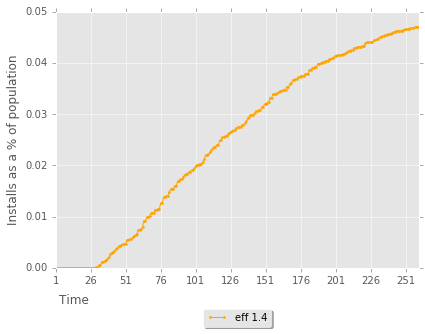

In [25]:
data_mode = 'bm_'
test_mode = 'inst'
column = ['N_installed_sum']
colors_ = ['orange', 'olive', 'olive','olive', 'lightcyan'] 
fig, axes_ = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(bottom=0.25)

#if ncols = 1  - transform into list
axes = [axes_]

ind = np.arange(N_TICKS)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

ind = dfs_w[0].index.values[0:N_TICKS_DISPLAY] + 1

lines = []

#markers = ["o-", "^-", "^-", "^-", "*-"]
markers = ["o-", "--", "--", "--", "*-"]
markerfacecolors = colors_
colors = ['r', 'r', 'r']
labels = ['eff ' + str(x) for x in np.linspace(1.0,1.5,5,endpoint=False)]

for i in range(N_TESTS) :
    pi, = axes[0].plot(ind, dfs_w[i][column][0:N_TICKS_DISPLAY]/5000, markers[i], label=labels[-i-1])
    pi.set_markerfacecolor(markerfacecolors[i])
    pi.set_color(markerfacecolors[i])
    pi.set_markeredgecolor(markerfacecolors[i])
    pi.set_markersize(2)
    lines.append(pi)
    

axes[0].set_xlabel("Time")
axes[0].xaxis.set_label_coords(0.05, -0.1)
axes[0].set_ylabel("Installs as a % of population")
    
# Shrink current axis's height by 10% on the bottom
box = axes[0].get_position()
axes[0].set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height * 0.8])

# Put a legend below current axis
lgd = axes[0].legend(lines, [l.get_label() for l in lines], loc='lower center', bbox_to_anchor=(0.5, -0.25),\
          fancybox=True, shadow=True, fontsize='10', ncol = 3)

axes[0].set_xlim([1,N_TICKS_DISPLAY])
start = 1
end = N_TICKS_DISPLAY
axes[0].xaxis.set_ticks(np.arange(start, end, 25))


plt.tight_layout()
plt.savefig('Simulation_results_' + data_mode + test_mode + '_Oct18' + '.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

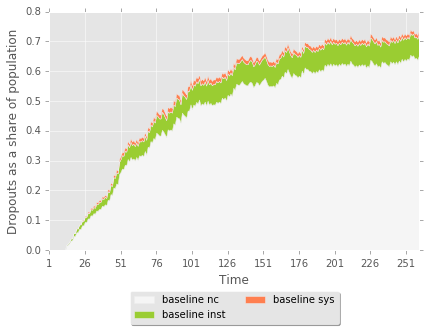

In [26]:
#number of dropouts as stacked bars
data_mode = 'bm_'
test_mode = 'drops'
fig, axes_ = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(bottom=0.25)

#reverse order of simulations
df_logs = dfs_logs[-1]

#if ncols = 1  - transform into list
axes = [axes_]

#axes_0_tw = axes[0].twinx()

ind = np.arange(N_TICKS)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

ind = df_logs.index.values[0:N_TICKS_DISPLAY] + 1

lines = []
i = 0

markers = ["ro", "r^", "r*"]
markerfacecolors = colors_
colors = ['r', 'r', 'r']
labels_raw = ["nc", "inst", "sys"]
labels = ['baseline ' + x for x in labels_raw]
data_ = []
markers_ = []
labels_ = []
colors_graph_ = []
data_columns = ['EParamTypes::HOStateDroppedOutNCDecStage',\
                   'EParamTypes::HOStateDroppedOutSEIStage',\
                   'EParamTypes::HOStateDroppedOutDesignStage',\
                   'EParamTypes::HONumberActiveAgents']

for column in data_columns[0:3]:
    data_.append(df_logs[column][0:N_TICKS_DISPLAY]/5000)
    markers_.append(markers[i])
    labels_.append(labels[i])
    colors_graph_.append(colors_[i])

    i = i + 1
    
pi = axes[0].stackplot(ind, data_, colors=tuple(['whitesmoke', 'yellowgreen', 'coral']), labels=tuple(labels_))
    


for pi_ in pi:
    lines.append(pi_)

    
markers = ["go", "g^", "g*"]
colors = ['g', 'g', 'g']
labels = ['high ef ' + x for x in labels_raw]

   

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Dropouts as a share of population")


#axes[0].set_autoscaley_on(False)
axes[0].set_xlim([1,N_TICKS_DISPLAY])
#axes_0_tw.set_ylim([0.0, 5.0])
start = 1
end = N_TICKS_DISPLAY
axes[0].xaxis.set_ticks(np.arange(start, end, 25))




# Shrink current axis's height by 10% on the bottom
box = axes[0].get_position()
axes[0].set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height * 0.8])

# Put a legend below current axis
lgd = axes[0].legend(lines, [l.get_label() for l in lines], loc='upper center', bbox_to_anchor=(0.5, -0.15),\
          fancybox=True, shadow=True, fontsize='10', ncol = 2)




plt.tight_layout()
plt.savefig('Simulation_results_' + data_mode + test_mode + '_Oct18' + '.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

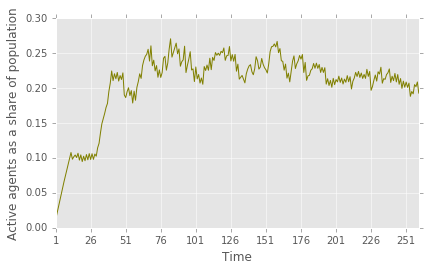

In [16]:
data_mode = 'bm_'
test_mode = 'active'

#do active agents figure
fig, axes_ = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(bottom=0.25)

#reverse order of simulations
df_logs = dfs_logs[-1]

#if ncols = 1  - transform into list
axes = [axes_]

#axes_0_tw = axes[0].twinx()

ind = np.arange(N_TICKS)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

ind = df_logs.index.values[0:N_TICKS_DISPLAY] + 1

lines = []
i = 0

column = 'EParamTypes::HONumberActiveAgents'
pi = axes[0].plot(ind, df_logs[column][0:N_TICKS_DISPLAY]/5000, color = 'olive')

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Active agents as a share of population")


#axes[0].set_autoscaley_on(False)
axes[0].set_xlim([1,N_TICKS_DISPLAY])
#axes_0_tw.set_ylim([0.0, 5.0])
start = 1
end = N_TICKS_DISPLAY
axes[0].xaxis.set_ticks(np.arange(start, end, 25))



plt.tight_layout()
plt.savefig('Simulation_results_' + data_mode + test_mode + '_Oct18' + '.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [28]:
#location x, location y 


# for each line - place into location
# average over locations
#
#

N_TILES = 10

test_mode = 'BaseVer01'
data_mode = 'CA'

#names of columns in a file
names = ['Tick', 'Location_x', 'Location_y', 'Uid', 'Price_per_watt', 'DC_size']

raw_data_per_tick = []
raw_data_dfs_per_tick = []
tick_bins = []
for i in range(4):
    #to store final results
    raw_data_per_tick.append(np.zeros((N_TILES, N_TILES)))
    #to store intermediate results
    raw_data_dfs_per_tick.append(np.zeros((N_SEEDS, N_TILES, N_TILES)))
    #tick edges
    tick_bins.append(N_TICKS/4 *(i))


#read few files
#save into database
dfs_ = []
#read last simulation result
files = glob.glob('..\\..\\ABMIRISLab\\Saves\\Oct-18-2017\\BaseModel\\'+ test_mode + '\\' + data_mode + \
                 '\\*[_pr].csv')
files.sort(key=os.path.getmtime, reverse=True)

#take top x files 
i_run = N_TESTS - 1

for file in files[i_run * N_SEEDS : (i_run + 1) * N_SEEDS]:
    df_ = pd.read_csv(file, names=names, low_memory=False, na_values = ['-nan(ind)'])
    dfs_.append(df_)

    
raw_data_dfs = np.zeros((len(dfs_), N_TILES, N_TILES))

indexes = [0.0, 0.0, 0.0, 0.0]

k = 0
for df_ in dfs_:
    
    
    
    for i in range(N_TILES):
        for j in range(N_TILES):
            index = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j)].index 
                             
            indexes[0] = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j) & \
                         (df_['Tick'] < tick_bins[0])].index
            
            indexes[1] = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j) & \
                         (df_['Tick'] < tick_bins[1])].index
            
            indexes[2] = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j) & \
                         (df_['Tick'] < tick_bins[2])].index
                             
            raw_data_dfs_per_tick[0][k, i, j] = df_.iloc[indexes[0]].shape[0]
            raw_data_dfs_per_tick[1][k, i, j] = df_.iloc[indexes[1]].shape[0]
            raw_data_dfs_per_tick[2][k, i, j] = df_.iloc[indexes[2]].shape[0]
            raw_data_dfs_per_tick[-1][k, i, j] = df_.iloc[index].shape[0]
            
    k = k + 1
    
    raw_data_per_tick[0] = np.mean(raw_data_dfs_per_tick[0], axis = 0)
    raw_data_per_tick[1] = np.mean(raw_data_dfs_per_tick[1], axis = 0)
    raw_data_per_tick[2] = np.mean(raw_data_dfs_per_tick[2], axis = 0)
    raw_data_per_tick[-1] = np.mean(raw_data_dfs_per_tick[-1], axis = 0)
    
    
#create df from them    
dfs_inst = dfs_

In [29]:
raw_data_per_tick[0] = np.zeros((N_TILES, N_TILES)) + 0.01
print(raw_data_per_tick[0])

[[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]]


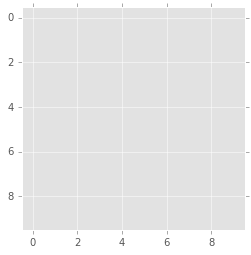

In [105]:
plt.imshow(raw_data_per_tick[0], cmap=new_cmap, interpolation='nearest')

In [33]:
max_installs = np.amax(raw_data_per_tick[3])
min_installs = 0 

In [34]:
print(max_installs)

6.0


In [35]:
import matplotlib.colors as colors

In [36]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [37]:
cmap = cm.get_cmap('Greys')
new_cmap = truncate_colormap(cmap, 0.2, 0.8)

In [38]:
raw_data_per_tick_norm = [0.0, 0.0, 0.0, 0.0]
for i in range(4):
    raw_data_per_tick_norm[i] = raw_data_per_tick[i] / max_installs

C:\Users\wilfeli\Anaconda3\envs\aimacro\lib\site-packages\ipykernel\__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\wilfeli\Anaconda3\envs\aimacro\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\wilfeli\Anaconda3\envs\aimacro\lib\site-packages\ipykernel\__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\wilfeli\Anaconda3\envs\aimacro\lib\site-packages\ipykernel\__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\wilfeli\Anaconda3\envs\aimacro\lib\site-packages\ipykernel\__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\w

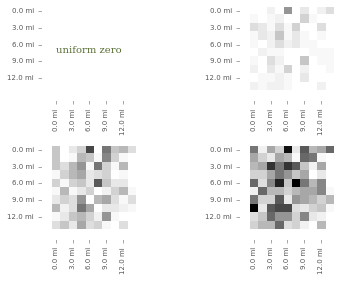

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=2)
#fig.subplots_adjust(bottom=0.5)


for i in range(4):
    lines = []

#    cmap_custom = cm.get_cmap('YlGn')
    cmap_custom = cm.get_cmap('Greys')
    #cmap_custom = new_cmap

    #image = np.random.uniform(size=(10, 10))
    axes[i/2, i%2].imshow(raw_data_per_tick[i], cmap=cmap_custom, interpolation='nearest', vmin=0, vmax=max_installs)

    #ax.set_title('Number of installations \n in a neighborhood')

    # Move left and bottom spines outward by 10 points
    axes[i/2, i%2].spines['left'].set_position(('outward', 10))
    axes[i/2, i%2].spines['bottom'].set_position(('outward', 10))
    # Hide the right and top spines
    axes[i/2, i%2].spines['right'].set_visible(False)
    axes[i/2, i%2].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axes[i/2, i%2].yaxis.set_ticks_position('left')
    axes[i/2, i%2].xaxis.set_ticks_position('bottom')
    
    for tick in axes[i/2, i%2].get_xticklabels():
        tick.set_rotation(90)
        tick.set_fontsize('x-small')
        
    for tick in axes[i/2, i%2].get_yticklabels():
        tick.set_fontsize('x-small')

    labels_ = ['mi']
    xs = range(10)

    from matplotlib.ticker import FuncFormatter, MaxNLocator
    def format_fn(tick_val, tick_pos):
        if int(tick_val) in xs:
            return str(tick_val * 1.5) + ' ' + labels_[0]
        else:
            return ''


    axes[i/2, i%2].xaxis.set_major_formatter(FuncFormatter(format_fn))
    axes[i/2, i%2].yaxis.set_major_formatter(FuncFormatter(format_fn))

    axes[i/2, i%2].grid(False)




#    handles, labels = ax.get_legend_handles_labels()

    # Put a legend below current axis
    #lgd = ax.legend(handles, ['test'], loc='lower center', bbox_to_anchor=(0.5, -0.25),\
    #          fancybox=True, shadow=True, fontsize='10', ncol = 2)

    
#add comment to the first plot
font = {'family': 'serif',
        'color':  'darkolivegreen',
        'weight': 'normal',
        'size': 10,
        }
axes[0,0].text(0.0, 5.0, 'uniform zero', fontdict=font)
    

plt.tight_layout()
data_mode = 'test'
plt.savefig('Simulation_results_spatial_' + data_mode + '_Oct18' + '.png', dpi=300)

plt.show()

In [ ]:
#redo bubbles figure

In [41]:
dfs_agg_inst = []
for df_ in dfs_inst:

    df_['Count'] = 1
    grouped = df_.groupby('Uid', sort=False)
    df_agg = grouped.agg({'Price_per_watt' : np.median,\
             'DC_size' : np.median, \
            'Count' : np.sum})
    dfs_agg_inst.append(df_agg)
    
df_inst_all = pd.concat(dfs_agg_inst)
df_inst_mean = df_agg.groupby(level=0).mean()

In [42]:
df_inst_mean.head()

,DC_size,Price_per_watt,Count
Uid,,,
40,7591.30,3.49348,15
41,6901.18,3.74361,25
42,5520.95,4.38156,25
43,6501.57,3.69692,17
44,6211.06,4.03440,9


In [48]:
#sort by count?
df_inst_mean = df_inst_mean.sort_values('Count', ascending=False)

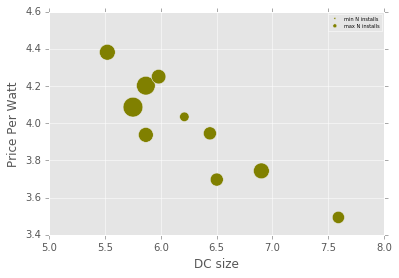

In [49]:
N = 10





x = df_inst_mean['DC_size']/1000
y = df_inst_mean['Price_per_watt']
norm = matplotlib.colors.Normalize(vmin=df_inst_mean['Count'].values[N-1], vmax=df_inst_mean['Count'].values[0])
cmap_custom = cm.get_cmap('Spectral')
area = norm(df_inst_mean['Count'])
color = []

for area_x in area:
#    color.append(cmap_custom(area_x/2))
    color.append('olive')
    

    
#color[1] = (0.0, 0.65, 0.75, 1.0)
    
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('DC size')
ax.set_ylabel('Price Per Watt')

#ax.set_autoscaley_on(False)
#ax.set_xlim([0,0.2])
#ax.set_ylim([0,5])
    
#plt.xlabel('Price Per Watt')
#plt.ylabel('System Size AC')
#plt.title('Number of Installations Per Company')

ax.scatter(x, y, s=df_inst_mean['Count'] * 10,  c = color )
handles, labels = ax.get_legend_handles_labels()


#names are here
#df_agg.index.values[0:3]

#colors are here
#color[0:3]

artists = []
labels = []

#create custom artists
#for i in range(3):
#    artists.append(mpatches.Circle((0, 0), 1.0, facecolor=color[i]))
#    labels.append(df_agg_dm1.index.values[i])

artists.append(mpatches.Circle((0, 0), 1.0, facecolor=color[-1], label='min'))
labels.append('min N installs')
artists.append(mpatches.Circle((0, 0), 1.0, facecolor=color[0], label='max'))
labels.append('max N installs')
    

class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
#        print(orig_handle.__dict__)
        radius_ = width/10
        if ('max' in orig_handle._label):
            radius_ = width/5
    
        p = mpatches.Circle(xy=center, radius=radius_)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]
    

#Create legend from custom artist/label lists
ax.legend(artists,
          labels,
         handler_map={mpatches.Circle: HandlerEllipse()}, bbox_to_anchor=(0.9, 0.9),
           bbox_transform=plt.gcf().transFigure, fontsize=5
         )



#plt.scatter(x, y, s=df_agg_top['Count'],  c = color )
data_mode = 'test'
plt.savefig('Simulation_results_installers_' + data_mode + '_Oct18' + '.png', dpi=300)
plt.show()

In [117]:
print(mpatches.Circle((0, 0), 5.0, facecolor=color[0]).__dict__)

{'_rasterized': None, '_clippath': None, '_linestyle': 'solid', '_clipon': True, '_animated': False, '_path': Path(array([[ 0.        , -1.        ],
       [ 0.2652031 , -1.        ],
       [ 0.51957987, -0.89463369],
       [ 0.70710678, -0.70710678],
       [ 0.89463369, -0.51957987],
       [ 1.        , -0.2652031 ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.2652031 ],
       [ 0.89463369,  0.51957987],
       [ 0.70710678,  0.70710678],
       [ 0.51957987,  0.89463369],
       [ 0.2652031 ,  1.        ],
       [ 0.        ,  1.        ],
       [-0.2652031 ,  1.        ],
       [-0.51957987,  0.89463369],
       [-0.70710678,  0.70710678],
       [-0.89463369,  0.51957987],
       [-1.        ,  0.2652031 ],
       [-1.        ,  0.        ],
       [-1.        , -0.2652031 ],
       [-0.89463369, -0.51957987],
       [-0.70710678, -0.70710678],
       [-0.51957987, -0.89463369],
       [-0.2652031 , -1.        ],
       [ 0.        , -1.        ],
       [ 0

In [57]:
y_start = 0.2
y_target = 0.5
theta_learn = 0.99
y_prog_ = [y_start]
x_tick_ = []
for i in range(200):
    y_prog_.append(y_prog_[-1] * theta_learn + y_target * (1 - theta_learn))
    x_tick_.append(i)

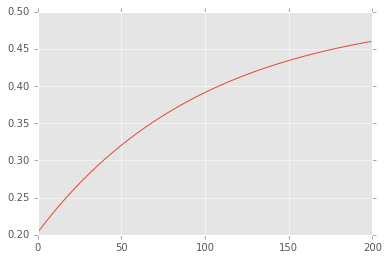

In [58]:
plt.plot(x_tick_, y_prog_[1:])